<h1> Time series prediction, end-to-end </h1>

This notebook illustrates several models to find the next value of a time-series:
<ol>
<li> Linear
<li> DNN
<li> CNN 
<li> RNN
</ol>

In [13]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-4e648d718abd74a4'
PROJECT = 'qwiklabs-gcp-4e648d718abd74a4'
REGION = 'us-east1'
SEQ_LEN = 50

In [14]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['SEQ_LEN'] = str(SEQ_LEN)
os.environ['TFVERSION'] = '1.8'

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [15]:
import tensorflow as tf
print(tf.__version__)

1.8.0


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


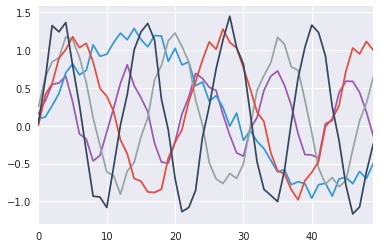

In [16]:
import numpy as np
import seaborn as sns

def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  noise = [np.random.random()*0.3 for i in range(SEQ_LEN)] # -0.3 to +0.3 uniformly distributed
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl + noise
  return x

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
  sns.tsplot( create_time_series(), color=flatui[i%len(flatui)] );  # 5 series

In [17]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in range(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

import os
try:
  os.makedirs('data/sines/')
except OSError:
  pass

np.random.seed(1) # makes data generation reproducible

to_csv('data/sines/train-1.csv', 1000)  # 1000 sequences
to_csv('data/sines/valid-1.csv', 250)

In [18]:
!head -5 data/sines/*-1.csv

==> data/sines/train-1.csv <==
3.431244520346599e-05,0.4612394382104329,0.750117333010706,1.002669376511136,1.2076602884326402,1.323506095651725,1.2917387402358318,1.1764893692792453,0.886910345640603,0.6411525584650162,0.13022616813814403,-0.04087557975624989,-0.64056082916097,-0.7308413932916386,-1.0019909717193467,-1.0483403299809841,-1.1477784066127428,-0.9920536687688593,-0.5735623980981127,-0.20876600013275354,-0.04353401093422207,0.4448081587286241,0.852311158877592,1.1544049946506432,1.124500783220232,1.2198949242663033,1.2542345078878991,1.348212988041884,0.8933280758140663,0.6876422148460588,0.4931601512698732,-0.009206099524738082,-0.3205687472911766,-0.742583738874477,-0.8613371947565367,-0.9461685863974377,-1.2073519868002527,-0.8895532550825337,-0.6144488415480625,-0.39713542151217374,-0.18923575720760066,0.33744428272940225,0.49615270709044407,0.9201515973512377,1.3047620284915646,1.2692019873446236,1.3048558847266711,1.1798764955714098,0.9612944770102272,0.8835284601061

<h3> Train model locally </h3>

Make sure the code works as intended.

In [19]:
%%bash
DATADIR=$(pwd)/data/sines
OUTDIR=$(pwd)/trained/sines
rm -rf $OUTDIR
gcloud ml-engine local train \
   --module-name=sinemodel.task \
   --package-path=${PWD}/sinemodel \
   -- \
   --train_data_path="${DATADIR}/train-1.csv" \
   --eval_data_path="${DATADIR}/valid-1.csv"  \
   --output_dir=${OUTDIR} \
   --model=cnn --train_steps=10 --sequence_length=$SEQ_LEN

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:TF_CONFIG environment variable: {'job': {'job_name': 'sinemodel.task', 'args': ['--train_data_path=/content/datalab/notebooks/training-data-analyst/courses/machine_learning/deepdive/09_sequence/data/sines/train-1.csv', '--eval_data_path=/content/datalab/notebooks/training-data-analyst/courses/machine_learning/deepdive/09_sequence/data/sines/valid-1.csv', '--output_dir=/content/datalab/notebooks/training-data-analyst/courses/machine_learning/deepdive/09_sequence/trained/sines', '--model=cnn', '--train_steps=10', '--sequence_length=50']}, 'cluster': {}, 'environment': 'cloud', 'task': {}}
INFO:tensorflow:Using config: {'_evaluation_master': '', '_model_dir': '/c

<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine with more data.

In [20]:
import shutil
shutil.rmtree('data/sines', ignore_errors=True)
os.makedirs('data/sines/')
np.random.seed(1) # makes data generation reproducible
for i in range(0,10):
  to_csv('data/sines/train-{}.csv'.format(i), 1000)  # 1000 sequences
  to_csv('data/sines/valid-{}.csv'.format(i), 250)

In [21]:
%%bash
gsutil -m rm -rf gs://${BUCKET}/sines/*
gsutil -m cp data/sines/*.csv gs://${BUCKET}/sines

CommandException: 1 files/objects could not be removed.
Copying file://data/sines/train-0.csv [Content-Type=text/csv]...
Copying file://data/sines/train-1.csv [Content-Type=text/csv]...
Copying file://data/sines/train-2.csv [Content-Type=text/csv]...
Copying file://data/sines/train-3.csv [Content-Type=text/csv]...
Copying file://data/sines/train-4.csv [Content-Type=text/csv]...
Copying file://data/sines/train-5.csv [Content-Type=text/csv]...
Copying file://data/sines/train-6.csv [Content-Type=text/csv]...
Copying file://data/sines/train-7.csv [Content-Type=text/csv]...
Copying file://data/sines/train-8.csv [Content-Type=text/csv]...
Copying file://data/sines/train-9.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-0.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-1.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-2.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-3.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-4.

In [22]:
%%bash
for MODEL in linear dnn cnn rnn rnn2 rnnN; do
  OUTDIR=gs://${BUCKET}/sinewaves/${MODEL}
  JOBNAME=sines_${MODEL}_$(date -u +%y%m%d_%H%M%S)
  gsutil -m rm -rf $OUTDIR
  gcloud ml-engine jobs submit training $JOBNAME \
     --region=$REGION \
     --module-name=sinemodel.task \
     --package-path=${PWD}/sinemodel \
     --job-dir=$OUTDIR \
     --scale-tier=BASIC \
     --runtime-version=$TFVERSION \
     -- \
     --train_data_path="gs://${BUCKET}/sines/train*.csv" \
     --eval_data_path="gs://${BUCKET}/sines/valid*.csv"  \
     --output_dir=$OUTDIR \
     --train_steps=3000 --sequence_length=$SEQ_LEN --model=$MODEL
done

jobId: sines_linear_190607_182113
state: QUEUED
jobId: sines_dnn_190607_182116
state: QUEUED
jobId: sines_cnn_190607_182120
state: QUEUED
jobId: sines_rnn_190607_182124
state: QUEUED
jobId: sines_rnn2_190607_182127
state: QUEUED
jobId: sines_rnnN_190607_182131
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [sines_linear_190607_182113] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe sines_linear_190607_182113

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs sines_linear_190607_182113
CommandException: 1 files/objects could not be removed.
Job [sines_dnn_190607_182116] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe sines_dnn_190607_182116

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs sines_dnn_190607_182116
CommandException: 1 files/objects could not be removed.
Job [sines_cnn_190607_182120] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe sines_cnn_190607_182120

or continue streami

## Monitor training with TensorBoard

Use this cell to launch tensorboard. If tensorboard appears blank try refreshing after 5 minutes

In [23]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/sinewaves'.format(BUCKET))

TensorBoard was started successfully with pid 3986. Click here to access it.

3986

In [24]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

Stopped TensorBoard with pid 3986


## Results

When I ran it, these were the RMSEs that I got for different models:

| Model | Sequence length | # of steps | Minutes | RMSE |
| --- | ----| --- | --- | --- | 
| linear | 50 | 3000 | 10 min | 0.150 |
| dnn | 50 | 3000 | 10 min | 0.101 |
| cnn | 50 | 3000 | 10 min | 0.105 |
| rnn | 50 | 3000 | 11 min | 0.100 |
| rnn2 | 50 | 3000 | 14 min |0.105 |
| rnnN | 50 | 3000 | 15 min | 0.097 |

### Analysis
You can see there is a significant improvement when switching from the linear model to non-linear models. But within the the non-linear models (DNN/CNN/RNN) performance for all is pretty similar. 

Perhaps it's because this is too simple of a problem to require advanced deep learning models. In the next lab we'll deal with a problem where an RNN is more appropriate.

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License